<H2> Parameter Estimation Using PINNS <H2>

In [60]:
#Might need revision

<h4> Simulate Plasma(Simplistic) <h4>

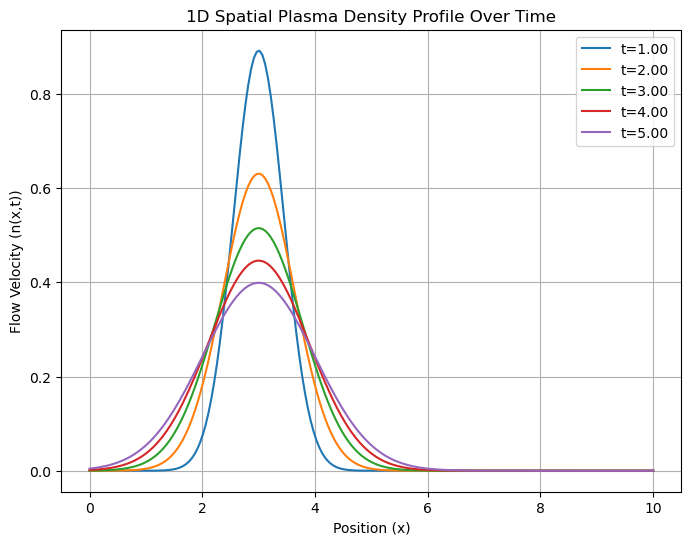

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate plasma density as a function of space and time
def plasma_density(x, t, n0, D, x0):
    return (n0 / np.sqrt(4 * np.pi * D * t)) * np.exp(-(x - x0)**2 / (4 * D * t))

# Parameters
n0 = 1.0      # Initial peak plasma density
x0 = 3.0      # Initial peak position
D = 0.1       # Diffusion coefficient
x_min, x_max = 0, 10  # Spatial range
t_min, t_max = 1.0, 5.0  # Time range (avoid t=0 to prevent division by zero)

# Generate spatial points and time points
x = np.linspace(x_min, x_max, 200)  # 200 spatial points
t = np.linspace(t_min, t_max, 5)    # 5 time points

# Create an n by m array to store plasma density values
plasma_density_array = np.zeros((len(x), len(t)))

# Calculate the plasma density for each time point and store it in the array
for i, t_ in enumerate(t):
    plasma_density_array[:, i] = plasma_density(x, t_, n0, D, x0)

# Plot the plasma density at different times
plt.figure(figsize=(8, 6))
for i, t_ in enumerate(t):
    plt.plot(x, plasma_density_array[:, i], label=f't={t_:.2f}')

# Labels and title
plt.xlabel('Position (x)')
plt.ylabel('Flow Velocity (n(x,t))')
plt.title('1D Spatial Plasma Density Profile Over Time')
plt.grid(True)
plt.legend()
plt.show()

<h4> Train PINN for Parameter Estimation with a modified driven Burger's equation <h4>

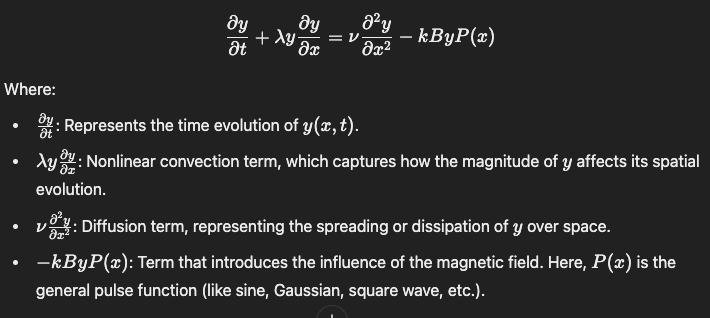

In [2]:
# torch and numpy imports
import torch
import torch.nn as nn                    
import numpy as np

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
X = torch.tensor(X.T).float()
T = torch.tensor(T.T).float()
y_real = torch.tensor(plasma_density_array).float()

In [31]:
print(X.shape, T.shape, y_real.shape)

torch.Size([200, 5]) torch.Size([200, 5]) torch.Size([200, 5])


In [4]:
def plot3D(X, T, y):
    X = X.detach().numpy()
    T = T.detach().numpy()
    y = y.detach().numpy()

    #     2D
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    cm = ax1.contourf(T, X, y, 20,cmap="viridis")
    fig.colorbar(cm, ax=ax1) # Add a colorbar to a plot
    ax1.set_title('u(x,t)')
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_aspect('equal')
        #     3D
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(T, X, y,cmap="viridis")
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.set_zlabel('u(x,t)')
    fig.tight_layout()

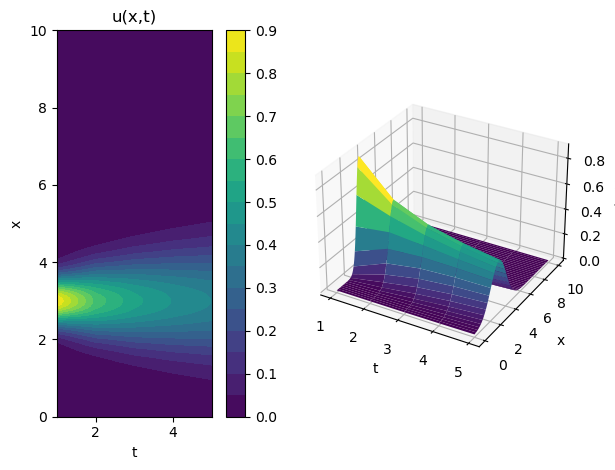

In [5]:
plot3D(X, T, y_real) 

In [6]:
X_test = X.reshape(-1,1)
T_test = T.reshape(-1,1)
Y_test = y_real.reshape(-1,1) 

In [7]:
total_points=len(x)*len(t)

Nf = 400  # Nf: Number of collocation points 

# Obtain random points of our PDE measurements y(x,t)
id_f = np.random.choice(total_points, Nf, replace=False)# Randomly chosen points for Interior
X_train_Nu = X_test[id_f]
T_train_Nu = T_test[id_f]
Y_train_Nu = Y_test[id_f]

In [8]:
print("We have",total_points,"points. We will select",X_train_Nu.shape[0],"points to train our model.")

We have 1000 points. We will select 400 points to train our model.


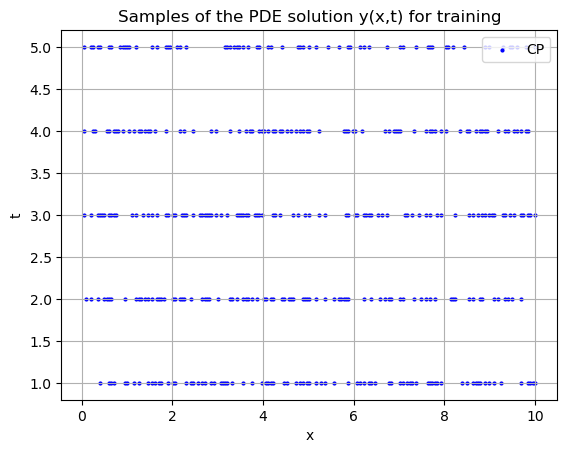

In [9]:
# visualize collocation points for 2D input space (x, t)
plt.figure()
plt.scatter(X_train_Nu.detach().numpy(), T_train_Nu.detach().numpy(),
            s=4., c='blue', marker='o', label='CP')
plt.title('Samples of the PDE solution y(x,t) for training')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('t')
plt.legend(loc='upper right')
plt.show()
plt.show(block=True)

In [10]:
from neuromancer.dataset import DictDataset

# turn on gradients for PINN
X_train_Nu.requires_grad=True
T_train_Nu.requires_grad=True

# Training dataset
train_data = DictDataset({'x': X_train_Nu, 't':T_train_Nu, 'y':Y_train_Nu}, name='train')
# test dataset
test_data = DictDataset({'x': X_test, 't':T_test, 'y':Y_test}, name='test')

# torch dataloaders
batch_size = X_train_Nu.shape[0]  # full batch training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         collate_fn=test_data.collate_fn,
                                         shuffle=False)

In [11]:
from neuromancer.modules import blocks
from neuromancer.system import Node

# neural net to solve the PDE problem bounded in the PDE domain 
net = blocks.MLP(insize=2, outsize=1, hsizes=[32, 32], nonlin=nn.Tanh)

# symbolic wrapper of the neural net
pde_net = Node(net, ['x', 't'], ['y_hat'], name='net')

In [12]:
# evaluate forward pass on the train data
net_out = pde_net(train_data.datadict)
net_out['y_hat'].shape

torch.Size([400, 1])

In [13]:
from neuromancer.constraint import variable

# symbolic Neuromancer variables
y = variable('y')           # PDE measurements from the dataset
y_hat = variable('y_hat')  # PDE solution generated as the output of a neural net (pde_net)
t = variable('t')          # temporal domain
x = variable('x')          # spatial domain
# trainable parameters with initial values
lamb = variable(torch.nn.Parameter(torch.tensor(2.0)), display_name='lambda')       # trainable PDE parameter lambda
nu = variable(torch.nn.Parameter(torch.tensor(0.01)), display_name='nu')             # trainable PDE parameter nu
k = variable(torch.nn.Parameter(torch.tensor(0.2)), display_name='k')  # trainable PDE parameter k
B = 0.45  #Fixed magnetic field

In [14]:
#Define a pulse type

import torch

# Define a general pulse function
def pulse_function(x, omega=0.3, pulse_type="sine"):
    """
    Generalized pulse function for the magnetic field influence.

    Parameters:
    - x: The spatial variable (can be a tensor in the context of PINN)
    - B: The magnetic field strength (constant)
    - pulse_type: Type of pulse ("sine", "square", "gaussian", etc.)

    Returns:
    - Pulse-modulated value
    """
    if pulse_type == "sine":
        return torch.sin(omega * x)
    elif pulse_type == "square":
        return torch.sign(torch.sin(omega * x))  # Example of a square wave
    elif pulse_type == "gaussian":
        return torch.exp(-((omega*x - 0.5)**2) / (2 * (0.1)**2))  # Example Gaussian pulse
    # Add more pulse types as needed
    else:
        raise ValueError(f"Unknown pulse type: {pulse_type}")

In [15]:
import torch

# Get the symbolic derivatives
dy_dt = y_hat.grad(t)       # Time derivative of y_hat
dy_dx = y_hat.grad(x)       # Spatial derivative of y_hat
d2y_d2x = dy_dx.grad(x)     # Second spatial derivative of y_hat

# Apply the pulse function (default to sine wave)
pulse_term = pulse_function(x, omega=0.3, pulse_type="sine")  # You can change "sine" to another type

# Update the PINN form with fixed magnetic field B and coupling constant k
f_pinn = dy_dt + lamb * y_hat * dy_dx - nu * d2y_d2x + k * B * y_hat * pulse_term

In [16]:
# scaling factor for better convergence
scaling = 1000.

# PDE CP loss
ell_1 = (f_pinn == 0.)^2

# PDE supervised learning loss
ell_2 = scaling*(y_hat == y)^2 

# ell_3 = output constraints to bound the PINN solution in the PDE output domain [0.0, 1.0]
con_1 = (y_hat <= 0.0)^2
con_2 = (y_hat >= 1.0)^2

In [17]:
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem

# create Neuromancer optimization loss
pinn_loss = PenaltyLoss(objectives=[ell_1, ell_2], constraints=[con_1, con_2])

# construct the PINN optimization problem
problem = Problem(nodes=[pde_net],      # list of nodes (neural nets) to be optimized
                  loss=pinn_loss,       # physics-informed loss function
                  grad_inference=True   # argument for allowing computation of gradients at the inference time)
                 )

In [18]:
from neuromancer.trainer import Trainer

optimizer = torch.optim.AdamW(problem.parameters(), lr=0.001)
epochs = 2000

#  Neuromancer trainer
trainer = Trainer(
    problem.to(device),
    train_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=200,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs,
    device=device
)

In [19]:
# Train PINN
best_model = trainer.train()

/Users/bedabratachoudhury/miniconda3/envs/myenv/lib/python3.9/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 33.61063003540039
epoch: 200  train_loss: 10.53890323638916
epoch: 400  train_loss: 4.903103351593018
epoch: 600  train_loss: 3.033155918121338
epoch: 800  train_loss: 2.2041168212890625
epoch: 1000  train_loss: 1.6650961637496948
epoch: 1200  train_loss: 1.3267496824264526
epoch: 1400  train_loss: 1.132840871810913
epoch: 1600  train_loss: 1.0304856300354004
epoch: 1800  train_loss: 0.9720341563224792


In [27]:
# evaluate trained PINN on test data
PINN = problem.nodes[0].cpu()
y1 = PINN(test_data.datadict)['y_hat']

# arrange data for plotting
y_pinn = y1.reshape(shape=[200,5]).detach().cpu()

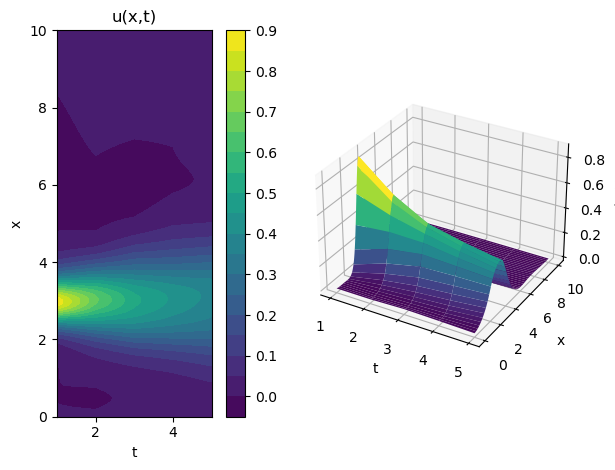

In [28]:
# plot PINN solution
plot3D(X, T, y_pinn)

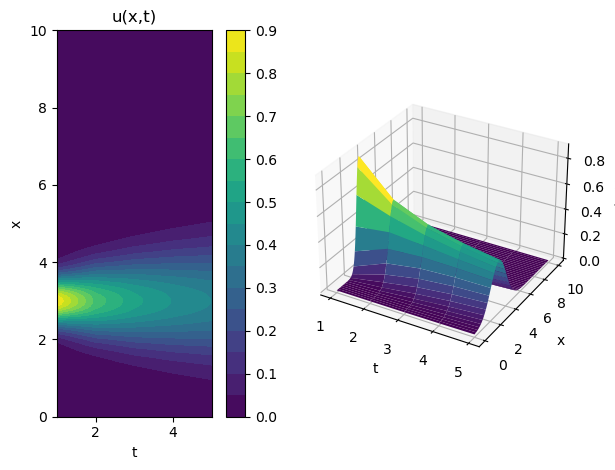

In [29]:
# plot exact PDE solution
plot3D(X, T, y_real)

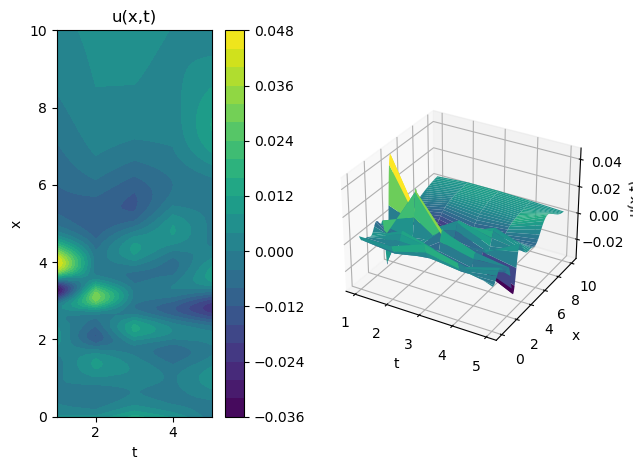

In [30]:
# plot residuals PINN - exact PDE
plot3D(X, T, y_pinn-y_real)

In [32]:
print('Estimated parameter lambda = ', float(lamb.value))
print('Estimated parameter nu = ', float(nu.value))
print('Estimated parameter k = ', float(k.value))

Estimated parameter lambda =  0.053503744304180145
Estimated parameter nu =  0.050918761640787125
Estimated parameter k =  0.11418401449918747


<h4> Use Estimated Parameters from PINN-s for one-shot optimization based control <h4>

In [33]:
#Ideally the initial state should also be passed as an input to the controller class

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class MagneticFieldController:
    def __init__(self, Nx, L, dt, Nt, nu, lambda_param, k, final_mag_field, initial_magnetic_field, initial_density):
        self.Nx = Nx                          # Number of spatial points
        self.L = L                            # Length of the domain
        self.dx = L / (Nx - 1)                # Spatial resolution
        self.dt = dt                          # Time step for stability
        self.Nt = Nt                          # Number of time steps
        self.nu = nu                          # Fixed magnetic viscosity
        self.lambda_param = lambda_param      # Fixed nonlinear parameter
        self.k = k
        self.final_mag_field = 1.3
        self.initial_magnetic_field = np.log(0.04)
        self.initial_density = initial_density
        # Coefficient for magnetic field influence

        self.magnetic_field_history = []      # To keep track of magnetic field values during optimization

    def pulse_function(self, x, omega=3.01, pulse_type="sine"):
        """Generate a pulse function based on the specified type."""
        if pulse_type == "sine":
            return np.sin(omega * x)
        elif pulse_type == "square":
            return np.sign(np.sin(omega * x))
        elif pulse_type == "gaussian":
            return np.exp(-((omega * x - 0.5) ** 2) / (2 * (0.1) ** 2))
        else:
            raise ValueError(f"Unknown pulse type: {pulse_type}")

    def burgers_solver(self, initial_density, B):
        """Solve the Burgers' equation with the given initial density and magnetic field."""
        n = np.zeros((self.Nx, self.Nt))  # Initialize density array
        n[:, 0] = initial_density            # Set initial state

        for n_idx in range(self.Nt - 1):
            n_prev = n[:, n_idx]
            dn_dx = (n_prev[2:] - n_prev[:-2]) / (2 * self.dx)
            dn_dx_full = np.zeros(self.Nx)
            dn_dx_full[1:-1] = dn_dx  # Assign computed values

            nonlinear_term = n_prev * self.lambda_param * dn_dx_full
            x_array = np.linspace(0, self.L, self.Nx)
            magnetic_field_term = self.k * B * self.pulse_function(x_array) * n_prev

            # Update interior points only
            n[1:-1, n_idx + 1] = (
                n_prev[1:-1]
                - self.dt * nonlinear_term[1:-1] 
                + self.nu * self.dt / self.dx**2 * (n_prev[2:] - 2 * n_prev[1:-1] + n_prev[:-2])
                - self.dt * magnetic_field_term[1:-1]
            )

            # Apply Dirichlet boundary conditions at every time step
            n[0, n_idx + 1] = n[0, 0]  # Fixed left boundary
            n[-1, n_idx + 1] = n[-1, 0]  # Fixed right boundary

        return n

    def cost_function(self, log_magnetic_field_value, initial_density, target_state):
        magnetic_field_value = np.exp(log_magnetic_field_value)
        self.magnetic_field_history.append(magnetic_field_value)
        n = self.burgers_solver(initial_density, magnetic_field_value)
        final_density = n[:, -1]
        # Calculate the loss
        loss = np.sum((final_density - target_state) ** 2)
        return loss

    def generate_initial_and_target(self):
        """Generate the initial density and the target state."""
        target_state = self.burgers_solver(self.initial_density, self.final_mag_field)[:, -1]  # Using B=1.3
        return self.initial_density, target_state

    def optimize_magnetic_field(self, lower_bound):
        """Optimize the magnetic field to match the target state."""
        result = minimize(
            self.cost_function, 
            self.initial_magnetic_field, 
            args=(self.initial_density, self.target_state), 
            method='Nelder-Mead',  
            options={'maxiter': 1000, 'disp': True}
        )

        if result.success:
            optimized_magnetic_field = np.exp(result.x[0])
            print(f"Optimization converged with message: {result.message}")
            return optimized_magnetic_field
        else:
            print(f"Optimization did not converge: {result.message}")
            return None

# Parameters
Nx = 80
L = 10.0
dt = 0.01
Nt = 200
nu_fixed = 0.0509187616407871254
lambda_fixed = 0.053503744304180145
k = 0.11418401449918747
final_mag_field=1.3

# Initialize the magnetic field as a single fixed value
initial_magnetic_field = np.log(0.04)  # Start with log of initial value

initial_density = np.exp(-((np.linspace(0, L, Nx) - L / 2) ** 2) / (2 * (0.35) ** 2))

# Create a controller instance
controller = MagneticFieldController(Nx, L, dt, Nt, 
                                     nu_fixed, lambda_fixed, k, 
                                     final_mag_field, initial_magnetic_field, 
                                     initial_density)

# Generate initial and target states
controller.initial_density, controller.target_state = controller.generate_initial_and_target()

# Optimize the magnetic field
optimized_magnetic_field = controller.optimize_magnetic_field(lower_bound)

# Calculate final density after optimization
final_density = controller.burgers_solver(controller.initial_density, optimized_magnetic_field)[:, -1]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 38
Optimization converged with message: Optimization terminated successfully.


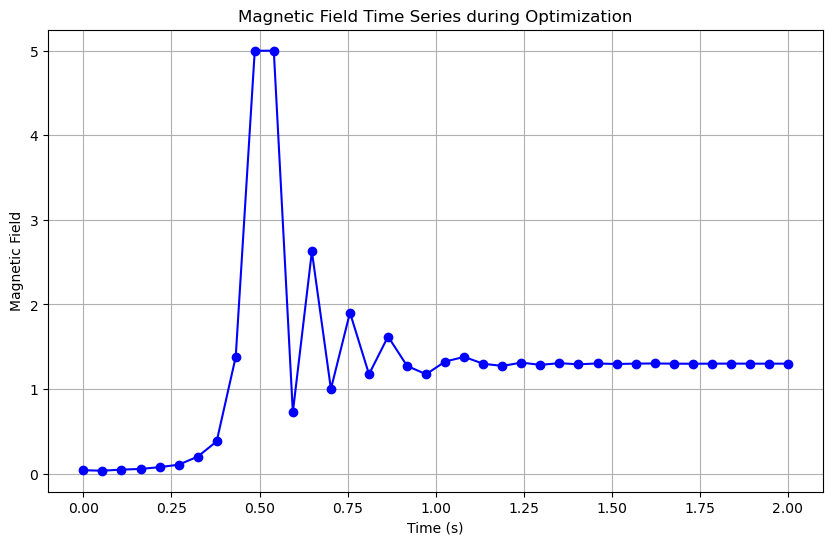

In [34]:
# Set the total simulation time based on the number of time steps and the time step size
total_time = Nt * dt  # Total time in seconds

# Generate time values for plotting based on the total simulation time
time_values = np.linspace(0, total_time, len(controller.magnetic_field_history))  # Linear space from 0 to total_time

# Plot the magnetic field history as a time series
plt.figure(figsize=(10, 6))
plt.plot(time_values, controller.magnetic_field_history, marker='o', linestyle='-', color='b')
plt.title('Magnetic Field Time Series during Optimization')
plt.xlabel('Time (s)')  # Assuming time is in seconds
plt.ylabel('Magnetic Field')  
plt.grid()
plt.show()

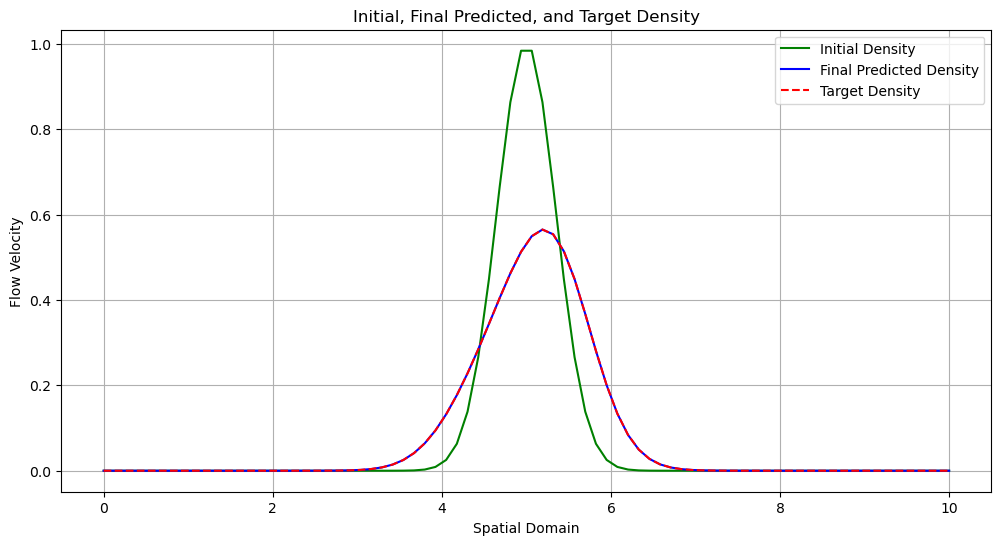

In [40]:
# Assuming the code above is defined up to the optimization step

# After generating initial and target states and performing the optimization
# We will plot the last predicted density against the target state

# Convert outputs to a NumPy array for easier handling
# Note: Assuming 'outputs' contains the simulation results, if not, please use final_density
outputs = np.array(controller.magnetic_field_history)  # Example: if you want to visualize magnetic field history

# Take the last output for plotting (you can also plot multiple if needed)
last_final_density = final_density  # Use the final density after optimization

# Plotting
plt.figure(figsize=(12, 6))

# Plotting the initial density
initial_density = controller.initial_density  # Use the initial density generated earlier
plt.plot(np.linspace(0, L, Nx), controller.initial_density, label='Initial Density', color='green')

# Plotting the final predicted density
plt.plot(np.linspace(0, L, Nx), last_final_density, label='Final Predicted Density', color='blue')

# Plotting the target density
plt.plot(np.linspace(0, L, Nx), controller.target_state, label='Target Density', color='red', linestyle='dashed')

# Adding labels and title
plt.xlabel('Spatial Domain')
plt.ylabel('Flow Velocity')
plt.title('Initial, Final Predicted, and Target Density')
plt.legend()
plt.grid()
plt.show()